In [1]:
from scipy.integrate import odeint
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline

## Dynamics
State
$$
x = \begin{pmatrix}
    x \\
    y \\
    v \\
    \theta
\end{pmatrix}
$$

Control
$$
u = \begin{pmatrix}
    v \\
    \phi
\end{pmatrix}
$$

Motion model
$$
\dot{x} = f(x,u) = \begin{pmatrix}
    \dot{x} \\
    \dot{y} \\
    \dot{v} \\
    \dot{\theta}
\end{pmatrix} = \begin{pmatrix}
    v \cos(\theta) \\
    v \sin(\theta) \\
    0 \\
    \frac{v}{B}\tan(\phi)
\end{pmatrix}
$$

Observation model
$$
y = \begin{pmatrix}
    x + \Delta{x} \\
    y + \Delta{y} \\
    v + \Delta{v} \\
    \theta + \Delta{\theta}
\end{pmatrix}
$$

$$
\Delta{x} = \iint_{k-1}^k (a_x\cos(\theta) + a_y\sin(\theta)) dt\\
\Delta{y} = \iint_{k-1}^k (a_x\sin(\theta) - a_y\cos(\theta)) dt\\
\Delta{v} = \int_{k-1}^k a_x dt \\
\Delta{\theta} = \int_{k-1}^k \omega_z dt
$$


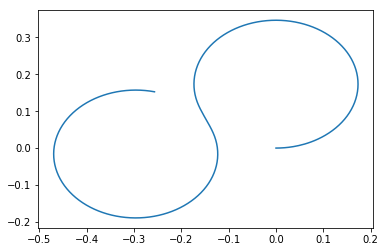

In [114]:
# base B
B = 0.1
control_freq = 50 #Hz
Ts = 1/control_freq

def dynamics(x, t, control):
    u = get_control_at_time(control, t)
    v = u[0]
    phi = u[1]
    theta = x[3]
    xd = v*np.cos(theta)
    yd = v*np.sin(theta)
    vd = 0
    thetad = v/B*np.tan(phi)
    return [xd, yd, vd, thetad]
    
def ramp_iter(u, limit):
    u = iter(u)
    u0 = next(u)
    yield u0
    for u1 in u:
        delta = u1-u0
        u1 = u0 + np.sign(delta) * min(limit, abs(delta))
        u0 = u1
        yield u1

def ramp(u, limit):
    return np.array(list(ramp_iter(u, limit)))

def get_control_at_time(u, t):
    k = int(t*control_freq)
    if k >= len(u):
        return u[-1] # hold last control input
    elif k < 0:
        return [0, 0]
    else:
        return u[k]

max_phi = 30 * np.pi / 180

phi = np.array([1,-1]).repeat(100)
phi = phi * max_phi
phi = ramp(phi, 10 * max_phi / control_freq)

max_acc = 1 # [m/s^2]
max_vel = 0.5 # [m/s]
v = max_vel * np.ones(len(phi))
v[0] = 0
v = ramp(v, max_acc / control_freq)

control = np.column_stack((v, phi))
sim_steps = len(control)
sim_time = sim_steps/control_freq
t = np.linspace(0, sim_steps/control_freq, sim_steps) # sec

x0 = [0,0,0,0]
sim = odeint(dynamics, x0, t, args=(control, ))

plt.plot(sim[:,0], sim[:,1])

In [115]:
x = sim[:,0]
y = sim[:,1]
v = control[:,0]
theta = sim[:,3]
omega = np.diff(theta)
omega=omega * control_freq
accx = np.diff(v) * control_freq
v = v[0:-1]
accy = v * omega

In [155]:
def measurement(x, z_imu, u):
    v = float(x[2][0])
    theta = x[3][0]
    ct = math.cos(theta)
    st = math.sin(theta)
    accx = z_imu[0]
    accy = z_imu[1]
    omega = z_imu[2]
    z = np.array([
        [(1/2*Ts**2*accx + v)*ct + 1/2*Ts**2*st],
        [(1/2*Ts**2*accx + v)*st - 1/2*Ts**2*ct],
        [Ts*accx],
        [Ts*omega]
    ])
    return x + z
    
def h(x):
    return x

# kalman filter
def kalman(x, P, u, z, t):
    theta = x[3][0]

    v = u[0]
    phi = u[1]
    I = np.identity(4)
    H = I
    F = np.matrix([[0,0,math.cos(theta),-v*math.sin(theta)],
                   [0,0,math.sin(theta), v*math.cos(theta)],
                   [0,0,0,0],
                   [0,0,1/B*math.tan(phi),0]])
    A = Ts*F + I
    
    
    # prediciton step
    out = odeint(dynamics, np.array(x).flatten(), [t, t + Ts], args=(control, ))[1]
    #x = np.array(out).reshape(4,1)
    x = A@x
    P = A@P@A.T + Q

    # Kalman gain
    S = H@P@H.T + R
    K = P@H.T @ np.linalg.pinv(S)

    # innovation
    y = z - h(x)
    # measurement correction step
    x = x + K @ y
    P = (I - K@H)@P@(I - K@H).T + K@R@K.T
    
    return x, P


qx = qy = qv = qt = 0.01
Q = np.array([[qx,0,0,0],
               [0,qy,0,0],
               [0,0,qv,0],
               [0,0,0,qt]])

sg = 0.05
sa = 0.1
rx = ry = 1/2*Ts**2*sa**2
rv = Ts*sa**2
rt = Ts*sg**2
R = np.array([[rx,0,0,0],
               [0,ry,0,0],
               [0,0,rv,0],
               [0,0,0,rt]])

accx_noise = sa*np.random.randn(len(accx))
accy_noise = sa*np.random.randn(len(accy))
gyro_noise = sg*np.random.randn(len(omega))

accx_bias = 0.05
accy_bias = 0.05
gyro_bias = 0.3

imu = np.column_stack((
    accx + accx_noise + accx_bias, 
    accy + accy_noise + accy_bias,
    omega + gyro_noise + gyro_bias))

P = np.diag([0.1, 0.1, 0.1, 0.1])
x = np.array([[0],[0],[0],[0]])

x_hist = []
P_hist = []

def save_state(x, P):
    global x_hist
    x_hist.append(x)
    P_hist.append(P)
    
def get_measurement_at_time(z, t):
    k = int(t*control_freq)
    if k >= len(z):
        return z[-1] # hold last control input
    elif k < 0:
        return [0, 0, 0]
    else:
        return z[k]

for k in range(0,sim_steps):
    t = k / control_freq
    u = get_control_at_time(control, t)
    raw = get_measurement_at_time(imu, t)
    z = measurement(x, raw, u)
    x, P = kalman(x, P, u, z, t)
    save_state(np.array(x.flat), P)


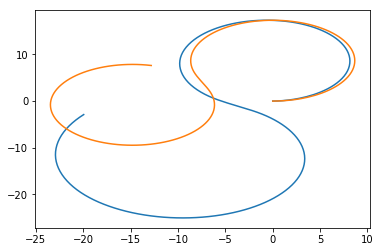

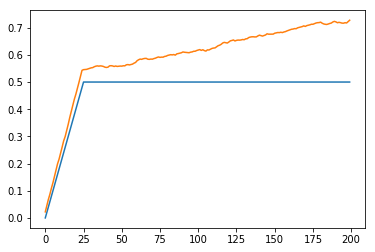

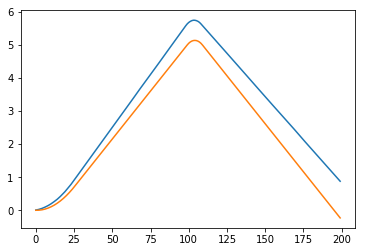

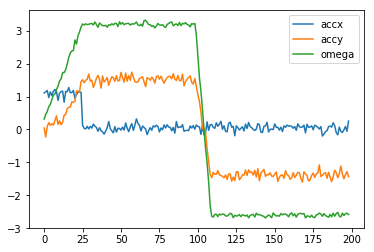

In [156]:
x_hist = np.array(x_hist)
x = x_hist[:,0]
y = x_hist[:,1]
theta = x_hist[:,3]
plt.plot(x, y, control_freq*sim[:,0], control_freq*sim[:,1])
plt.show()
plt.plot(control[:,0])
plt.plot(x_hist[:,2])
plt.show()
plt.plot(theta)
plt.plot(sim[:,3])
plt.show()
plt.plot(imu)
plt.legend(['accx', 'accy', 'omega'])
plt.show()
